In [24]:
# importing libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import datasets
from skimage import io, color, transform
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import cv2

# Set the directory where the current script resides as the working directory.
script_directory = os.path.dirname(os.path.abspath(__file__))
os.chdir(script_directory)

# Data Preprocessing

## Data Augmentation

In [45]:
def data_augmentation(input_folder, output_folder, target_size=(100, 100)):
    # Check if the output folder exists; if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through image files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            input_path = os.path.join(input_folder, filename)
            img = cv2.imread(input_path)

            # Resize the image to the target size
            img = cv2.resize(img, target_size)
            
            # Extract the original image name
            base_name = os.path.basename(input_path).split('.')[0]

            # Save the original image
            original_save_path = os.path.join(output_folder, f"{base_name}.jpg")
            cv2.imwrite(original_save_path, img)
            
            # Flip
            flipped_img = cv2.flip(img, 1)
            save_path = os.path.join(output_folder, f"{base_name}_a.jpg")
            cv2.imwrite(save_path, flipped_img)

            # Rotate by +10 degrees
            # Get the center of the image
            center = (img.shape[1]//2, img.shape[0]//2)
            # Calculate the rotation matrix
            matrix = cv2.getRotationMatrix2D(center, 10, 1.0)  # The arguments are (center, angle, scale)
            # Apply the rotation
            rotated_img1 = cv2.warpAffine(img, matrix, (img.shape[1], img.shape[0]))  # The arguments are (source image, rotation matrix, output image size)
            # Save the image
            save_path = os.path.join(output_folder, f"{base_name}_b.jpg")
            cv2.imwrite(save_path, rotated_img1)

            # Rotate by -10 degrees
            # Calculate the rotation matrix for -10 degrees
            matrix = cv2.getRotationMatrix2D(center, -10, 1.0)
            # Apply the rotation
            rotated_img2 = cv2.warpAffine(img, matrix, (img.shape[1], img.shape[0]))
            # Save the image
            save_path = os.path.join(output_folder, f"{base_name}_c.jpg")
            cv2.imwrite(save_path, rotated_img2)

            # Shift
            rows, cols, _ = img.shape
            M = np.float32([[1, 0, 10], [0, 1, 5]])
            shifted_img1 = cv2.warpAffine(img, M, (cols, rows))
            save_path = os.path.join(output_folder, f"{base_name}_d.jpg")
            cv2.imwrite(save_path, shifted_img1)

            M = np.float32([[1, 0, -5], [0, 1, -10]])
            shifted_img2 = cv2.warpAffine(img, M, (cols, rows))
            save_path = os.path.join(output_folder, f"{base_name}_e.jpg")
            cv2.imwrite(save_path, shifted_img2)

            # Add noise
            for i in range(3):
                noise = np.random.normal(loc=0, scale=25, size=img.shape)
                noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8)
                save_path = os.path.join(output_folder, f"{base_name}_{chr(ord('f') + i)}.jpg")
                cv2.imwrite(save_path, noisy_img)

# Example usage
data_augmentation("FaceData", "FaceData-2", target_size=(128, 128))

## Load and Preprocess the Images

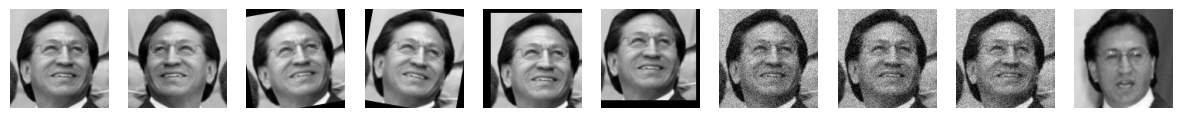

In [46]:
#Defines a function to read a picture
def load_face_data(directory):
    Faces = []
    Names = []

    # Visualize ten images horizontally
    plt.figure(figsize=(15, 1.5))  # Adjust the figure size as needed
    
    for k, i in enumerate(glob.glob(os.path.join(directory, "*"))):
        # Load image
        imagei = io.imread(i)

        # Extracting name from the file name
        Names.append(os.path.basename(i).split('_')[0])

        # Convert to grayscale image
        imagei_gray = color.rgb2gray(imagei)
        
        # Resize image to a fixed size
        image_rescaled = transform.resize(imagei_gray, output_shape=(128, 128), anti_aliasing=False)
        
        # Centering and Normalization
        mean_value = np.mean(image_rescaled)
        std_dev = np.std(image_rescaled)
        normalized_image = (image_rescaled - mean_value) / std_dev

        # Flatten and append the normalized image to Faces
        Faces.append(normalized_image.flatten())
        
        # Visualize ten images
        if k < 10:
            plt.subplot(1, 10, k + 1)
            plt.imshow(normalized_image, cmap='gray')
            plt.axis('off')
    
    plt.show()

    return Faces, Names

# v
faces, names = load_face_data("FaceData-2")

# Convert Names to integer labels using LabelEncoder
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(names)

# Convert integer labels to one-hot encoded labels using OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_labels = integer_labels.reshape(len(integer_labels), 1)
labels = onehot_encoder.fit_transform(integer_labels)

# PCA

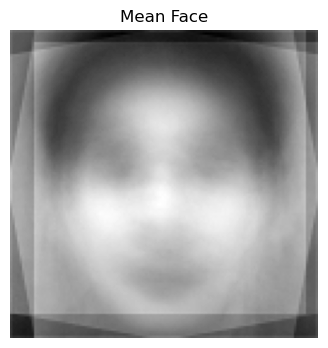

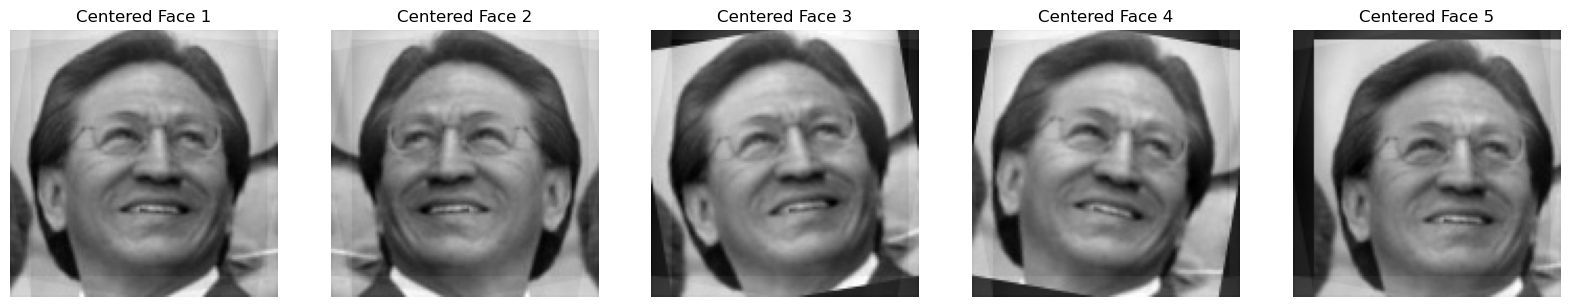

For explained variance ratio >= 90%, choose k=136


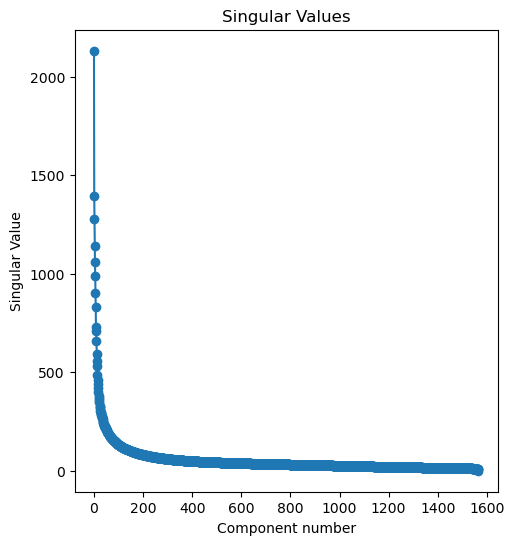

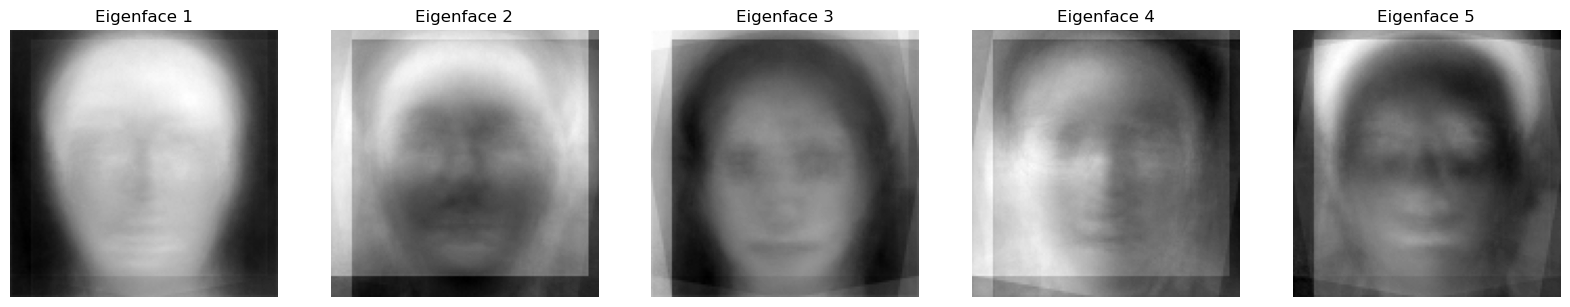

In [56]:
def SVD_PCA(faces, h=128, w=128, variance_ratio=0.99):
    # Compute the mean face and subtract it to center the dataset
    mean_face = np.mean(faces, axis=0)
    centered_faces = faces - mean_face

    # Display the mean face
    plt.figure(figsize=(4, 4))
    plt.imshow(mean_face.reshape((h, w)), cmap='gray')
    plt.axis('off')
    plt.title('Mean Face')
    plt.show()

    # Display the first 5 centered faces
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, ax in enumerate(axes):
        ax.imshow(centered_faces[i].reshape((h, w)), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Centered Face {i+1}')
    plt.show()

    # Perform SVD
    U, singular_values, Vt = np.linalg.svd(centered_faces, full_matrices=False)

    # Plotting the singular values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(singular_values, 'o-')
    plt.title('Singular Values')
    plt.xlabel('Component number')
    plt.ylabel('Singular Value')

    # Singular values to variance
    total_variance = np.sum(singular_values**2)
    k_value_with_90_ratio = None

    for k in range(20, 1000):
        explained_variance_ratio = np.sum(singular_values[:k]**2) / total_variance
        if explained_variance_ratio >= 0.90:
            k_value_with_90_ratio = k
            print(f"For explained variance ratio >= 90%, choose k={k_value_with_90_ratio}")
            break

    # Project the data onto the top k principal components
    principal_components = Vt[:k_value_with_90_ratio]  # Here, we use Vt directly because it's already aligned with the features
    projected_data = np.dot(centered_faces, principal_components.T)

    # Display the first 5 eigenfaces
    eigenfaces = Vt[:5].reshape((-1, h, w))
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, ax in enumerate(axes):
        ax.imshow(eigenfaces[i], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Eigenface {i+1}')
    plt.show()

    return projected_data, principal_components

# PCA was performed on the data
faces_PCA, principal_components = SVD_PCA(faces)

In [48]:
faces_PCA.shape

(1566, 136)

In [49]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Model testing and building

## Train_test_split

In [50]:
X = np.array(faces_PCA)
y = np.array(labels)

# Splitting the dataset into training and testing sets with 20% data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build MLP model

In [71]:
# import numpy as np
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import os
import random
from datetime import datetime  # Import module for handling dates and times

# Determine the number of classes from the training labels
num_classes = y_train.shape[1]

# Input shape is determined by the features of the dataset
input_shape = X_train.shape[1:]  

def create_face_recognition_model(input_shape, num_classes=10, activation='relu'):
    """Function to create the model architecture for face recognition."""
    model = models.Sequential([
        layers.Dense(512, input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization to prevent overfitting
        layers.Activation(activation),
        
        # Normalize the activations of the previous layer at each batch
        layers.BatchNormalization(),  
        
        # Dropout to prevent overfitting by randomly setting input units to 0
        layers.Dropout(0.5),  
        layers.Dense(256, kernel_regularizer=regularizers.l2(0.01)),
        layers.Activation(activation),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Softmax for multi-class classification
        layers.Dense(num_classes, activation='softmax')  
    ])
    return model

def compile_and_train(model, X_train, y_train, X_val, y_val, epochs=5, batch_size=32):
    """Compiles and trains the model, with early stopping and model checkpointing."""
    
    # Adam optimizer for efficient stochastic optimization
    optimizer = optimizers.RMSprop(learning_rate=0.001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Early stopping to halt training when validation loss ceases to decrease
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  
    
    # Save the best model during training
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])
    return history

def test_model(model, X_test, y_test):
    """Evaluates the model on the test set and returns the accuracy."""
    predictions = model.predict(X_test)
    accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))  # Calculate accuracy
    return accuracy

def random_search(X_train, y_train, X_test, y_test, n_iter=10):
    """Performs random search over hyperparameters to find the best model configuration."""
    best_accuracy = 0
    best_params = {}
    best_model = None

    for iteration in range(n_iter):
        params = {
            # Choose a random number of epochs 
            'epochs': random.choice(range(20, 51)),  
            # Choose a random batch size 
            'batch_size': random.choice(range(16, 65)),  
            # Choose a random activation function
            'activation': random.choice(['relu', 'sigmoid', 'tanh'])  
        }
        print("Testing parameters:", params)

        model = create_face_recognition_model(input_shape, num_classes=num_classes, activation=params['activation'])
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=iteration)  # Further split for validation
        
        compile_and_train(model, X_train_split, y_train_split, X_val_split, y_val_split, epochs=params['epochs'], batch_size=params['batch_size'])
        
        accuracy = test_model(model, X_test, y_test)
        print(f"Iteration: {iteration + 1}/{n_iter} - Accuracy: {accuracy}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            best_model = model      

    print("Best parameters:", best_params)
    print("Best accuracy:", best_accuracy)
    
    # Save the best model with a timestamp to distinguish between different runs
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    best_model.save(f'saved_model/best_model_final_{timestamp}.keras')

# Ensure the saved_model directory exists before running random search
if not os.path.exists('saved_model'):
    os.makedirs('saved_model')

# Start the random search with defined datasets
random_search(X_train, y_train, X_test, y_test, n_iter=10)

Testing parameters: {'epochs': 33, 'batch_size': 37, 'activation': 'sigmoid'}
Epoch 1/33
28/28 [==============================] - 1s 16ms/step - loss: 8.6179 - accuracy: 0.2298 - val_loss: 8.0523 - val_accuracy: 0.2072
Epoch 2/33
28/28 [==============================] - 0s 10ms/step - loss: 6.8454 - accuracy: 0.4785 - val_loss: 7.2651 - val_accuracy: 0.4542
Epoch 3/33
28/28 [==============================] - 0s 9ms/step - loss: 6.0124 - accuracy: 0.6034 - val_loss: 6.5118 - val_accuracy: 0.6335
Epoch 4/33
28/28 [==============================] - 0s 9ms/step - loss: 5.3598 - accuracy: 0.6643 - val_loss: 5.7942 - val_accuracy: 0.6972
Epoch 5/33
28/28 [==============================] - 0s 10ms/step - loss: 4.7137 - accuracy: 0.7652 - val_loss: 5.1138 - val_accuracy: 0.7530
Epoch 6/33
28/28 [==============================] - 0s 10ms/step - loss: 4.2523 - accuracy: 0.8042 - val_loss: 4.5582 - val_accuracy: 0.7769
Epoch 7/33
28/28 [==============================] - 0s 10ms/step - loss: 3.801

## Test a variety of commonly used models

In [61]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics

# Convert one-hot encoded labels back to 1D array
y_train_argmax = np.argmax(y_train, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

models=[]
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("KNN",KNeighborsClassifier(n_neighbors=5)))
models.append(("DT",DecisionTreeClassifier()))
models.append(("SVM",SVC()))


for name, model in models:
    
    clf=model

    clf.fit(X_train, y_train_argmax)

    y_pred=clf.predict(X_test)
    print(10*"=","{} Result".format(name).upper(),10*"=")
    print("Accuracy score:{:0.2f}".format(metrics.accuracy_score(y_test_argmax, y_pred)))
    print()

========== LDA RESULT ==========
Accuracy score:0.83

========== LR RESULT ==========
Accuracy score:0.84

========== NB RESULT ==========
Accuracy score:0.78

========== KNN RESULT ==========
Accuracy score:0.79



D:\Download\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


========== DT RESULT ==========
Accuracy score:0.64

========== SVM RESULT ==========
Accuracy score:0.87



# Real-time face detection and recognition

In [62]:
import cv2
from tensorflow.keras.models import load_model
from datetime import datetime
from skimage import io, color, transform

# Load the face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the face recognition model
# Note: Modify the model path
timestamp = datetime.now().strftime("2024-02-28_15-27-36")
model_path = f'saved_model/best_model_final_{timestamp}.keras'
model = load_model(model_path)

# Turn on the camera
cap = cv2.VideoCapture(0)

while True:
    # Capture video frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Face detection 
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
        # Face extraction
        face = frame[y:y+h, x:x+w]
        
        # Convert to grayscale image
        imagei_gray = color.rgb2gray(face)
        
        # Resize image to a fixed size
        image_rescaled = transform.resize(imagei_gray, output_shape=(128, 128), anti_aliasing=False)
        
        # Centering and Normalization
        mean_value = np.mean(image_rescaled)
        std_dev = np.std(image_rescaled)
        normalized_image = (image_rescaled - mean_value) / std_dev

        # Flatten the normalized image
        face = normalized_image.flatten()
        
        face = np.dot(face, principal_components.T)
        
        # Reshape the input to match the desired shape of the model
        face = face.reshape(1, -1)  # The shapes required by the model are (1, features)
        
        # Face recognition 
        prediction = model.predict(face)

        # Converts the result of One-Hot encoding back to an integer label
        predicted_integer = np.argmax(prediction, axis=1)

        # Use LabelEncoder's inverse_transform method to convert the integer label back to the original label
        predicted_names = label_encoder.inverse_transform(predicted_integer)

        # The prediction is displayed on the face box
        cv2.putText(frame, str(predicted_names[0]), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
    # Display result frame
    cv2.imshow('Face Detection', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Freeing camera resources
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 16ms/step
